# 1. EDA
- MRI 의료 데이터
- 캐글 UW-Madison GI Tract Image Segmentation 데이터셋 활용 (https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/data)
- 구글 코랩 이용

In [ ]:
# 구글 드라이브와 연결 - 생략 가능
from google.colab import drive  
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 파일이 있는 곳으로 이동 - 생략 가능
%cd /your_path

/content/drive/MyDrive/project/data/uw_image_segmentation


In [ ]:
# 위치 확인 - 생략가능
!ls

sample_submission.csv  train  train.csv


In [ ]:
# eda를 위한 필요 모듈
import cv2
import os
import matplotlib.pyplot as plt
import seaborn 
import numpy as np
import pandas as pd
from PIL import Image
from skimage import color
import glob
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# csv 파일 확인
train_csv = pd.read_csv('train.csv')
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115488 entries, 0 to 115487
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            115488 non-null  object
 1   class         115488 non-null  object
 2   segmentation  33913 non-null   object
dtypes: object(3)
memory usage: 2.6+ MB


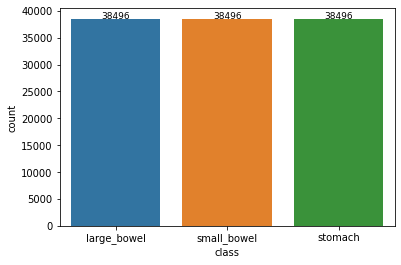

In [ ]:
# 먼저 얼마나 class에 얼마나 분류 되어 있는지 확인
cl_ax = seaborn.countplot(train_csv['class'])
for p in cl_ax.patches:
    height = p.get_height()
    cl_ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 9)
plt.show()

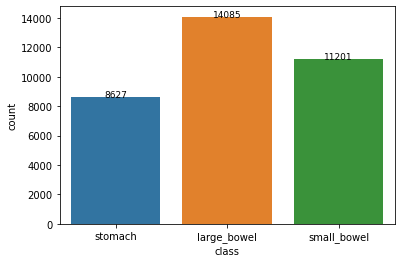

In [ ]:
# segmentiaion되어 있는 컬럼은 어떤 비율인지 확인
seg_cl_ax = seaborn.countplot(train_csv[train_csv['segmentation'].notnull()]['class'])
for p in seg_cl_ax.patches:
    height = p.get_height()
    seg_cl_ax.text(p.get_x() + p.get_width() / 2., height + 3, height, ha = 'center', size = 9)
plt.show()

In [ ]:
# glob을 이용해 이미지 불러오기 준비
TRAIN_DIR="your_path/train"
glob_img = glob.glob( TRAIN_DIR + '/*/*/*/*')

In [ ]:
#storing image path as the id and all the corresponding info
# 이미지 경로를 데이터 프레임에 추가하기 위한 함수 
def setup_img_info(x):
    name = x.split('/')[-1].split('_')
    img_name = ""
    img_name += x.split('/')[-3] + '_' + name[0]+'_'+name[1]
    height,width,h_pixel,w_pixel = (name[2],name[3],name[4],name[5].replace('.png',''))
    #print(img_name , height,width,h_pixel,w_pixel)
    return pd.Series([img_name , height ,width ,h_pixel ,w_pixel])



# 데이터 프레임을 만들기
image_details = pd.DataFrame()
# 이미지 경로 컬럼
image_details['img_path'] = glob_img
# 이미지 경로 컬럼을 이용해 컬럼 만들기
splits01 = image_details['img_path'].str.split("/", n = 7, expand = True)
image_details['Case_no_And_Day'] = splits01[2]
image_details['Slice_Info'] = splits01[4]

splits02 = image_details['Case_no_And_Day'].str.split("_", n = 2, expand = True)
image_details['Case_no'] = splits02[0].str[4:].astype(int)
image_details['Day'] = splits02[1].str[3:].astype(int)

splits03 = image_details['Slice_Info'].str.split("_", n = 6, expand = True)
image_details['Slice_no'] = splits03[1].astype(int)
# 함수를 이용해 컬럼 만들기
image_details[['id','height','width','h_pixel','w_pixel']] = image_details['img_path'].apply(lambda t : setup_img_info(t))



In [ ]:
# 확인
image_details.info()
image_details.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38496 entries, 0 to 38495
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   img_path         38496 non-null  object
 1   Case_no_And_Day  38496 non-null  object
 2   Slice_Info       38496 non-null  object
 3   Case_no          38496 non-null  int64 
 4   Day              38496 non-null  int64 
 5   Slice_no         38496 non-null  int64 
 6   id               38496 non-null  object
 7   height           38496 non-null  object
 8   width            38496 non-null  object
 9   h_pixel          38496 non-null  object
 10  w_pixel          38496 non-null  object
dtypes: int64(3), object(8)
memory usage: 3.2+ MB


,img_path,Case_no_And_Day,Slice_Info,Case_no,Day,Slice_no,id,height,width,h_pixel,w_pixel
0,train/case102/case102_day0/scans/slice_0001_36...,case102_day0,slice_0001_360_310_1.50_1.50.png,102,0,1,case102_day0_slice_0001,360,310,1.50,1.50
1,train/case102/case102_day0/scans/slice_0002_36...,case102_day0,slice_0002_360_310_1.50_1.50.png,102,0,2,case102_day0_slice_0002,360,310,1.50,1.50
2,train/case102/case102_day0/scans/slice_0003_36...,case102_day0,slice_0003_360_310_1.50_1.50.png,102,0,3,case102_day0_slice_0003,360,310,1.50,1.50
3,train/case102/case102_day0/scans/slice_0004_36...,case102_day0,slice_0004_360_310_1.50_1.50.png,102,0,4,case102_day0_slice_0004,360,310,1.50,1.50
4,train/case102/case102_day0/scans/slice_0005_36...,case102_day0,slice_0005_360_310_1.50_1.50.png,102,0,5,case102_day0_slice_0005,360,310,1.50,1.50


In [ ]:
# height width	h_pixel	w_pixel 컬럼 데이터 타입을 int, float로
image_details['height'] = image_details['height'].astype(int)
image_details['width'] = image_details['width'].astype(int)
image_details['h_pixel'] = image_details['h_pixel'].astype(float)
image_details['w_pixel'] = image_details['w_pixel'].astype(float)

In [ ]:
# 확인
image_details.info()
image_details.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38496 entries, 0 to 38495
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   img_path         38496 non-null  object 
 1   Case_no_And_Day  38496 non-null  object 
 2   Slice_Info       38496 non-null  object 
 3   Case_no          38496 non-null  int64  
 4   Day              38496 non-null  int64  
 5   Slice_no         38496 non-null  int64  
 6   id               38496 non-null  object 
 7   height           38496 non-null  int64  
 8   width            38496 non-null  int64  
 9   h_pixel          38496 non-null  float64
 10  w_pixel          38496 non-null  float64
dtypes: float64(2), int64(5), object(4)
memory usage: 3.2+ MB


,img_path,Case_no_And_Day,Slice_Info,Case_no,Day,Slice_no,id,height,width,h_pixel,w_pixel
0,train/case102/case102_day0/scans/slice_0001_36...,case102_day0,slice_0001_360_310_1.50_1.50.png,102,0,1,case102_day0_slice_0001,360,310,1.5,1.5
1,train/case102/case102_day0/scans/slice_0002_36...,case102_day0,slice_0002_360_310_1.50_1.50.png,102,0,2,case102_day0_slice_0002,360,310,1.5,1.5
2,train/case102/case102_day0/scans/slice_0003_36...,case102_day0,slice_0003_360_310_1.50_1.50.png,102,0,3,case102_day0_slice_0003,360,310,1.5,1.5
3,train/case102/case102_day0/scans/slice_0004_36...,case102_day0,slice_0004_360_310_1.50_1.50.png,102,0,4,case102_day0_slice_0004,360,310,1.5,1.5
4,train/case102/case102_day0/scans/slice_0005_36...,case102_day0,slice_0005_360_310_1.50_1.50.png,102,0,5,case102_day0_slice_0005,360,310,1.5,1.5


In [ ]:
# 이미지 중 사이즈 확인
print('Height of the images having 1.63 pixel spacing are ==>>'
      ,list(image_details[image_details['h_pixel']==1.63]['height'].unique()))
print('Height of the images having 1.5 pixel spacing are  ==>>'
      ,list(image_details[image_details['h_pixel']==1.5]['height'].unique()))

Height of the images having 1.63 pixel spacing are ==>> [276]
Height of the images having 1.5 pixel spacing are  ==>> [360, 266, 234]


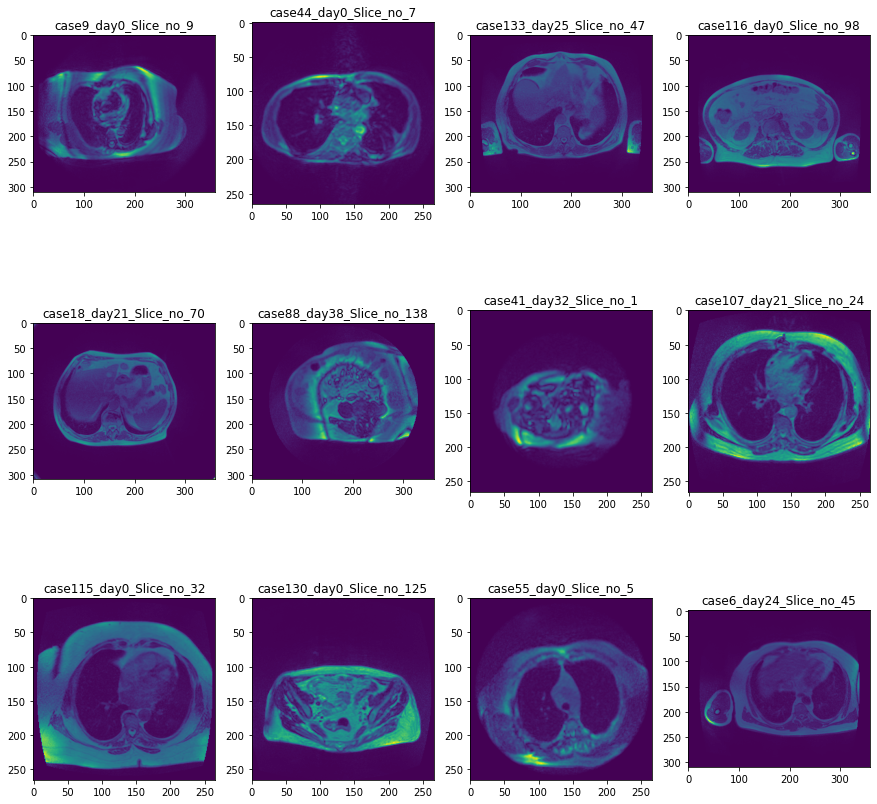

In [ ]:
# 라벨링 안된 원본 데이터 시각화

plt.subplots(figsize=(15,15))
for i in range(12):
  index = np.random.randint(0,image_details.shape[0])
  image = Image.open(image_details.loc[index, 'img_path'])
  image = np.array(image)

  plt.subplot(3,4, i + 1)

  title = (image_details.loc[index, 'Case_no_And_Day'] + 
           '_Slice_no_' + str(image_details.loc[index, 'Slice_no']))

  plt.title(title)
  plt.imshow(np.interp(image, [np.min(image), np.max(image)], [0,255]))

  
plt.show()

In [ ]:
# segmentation이 된 데이터만 갖고오기
mask_data = train_csv[train_csv['segmentation'].notnull()]
# 인덱스 추출
index_list = list(mask_data.index)
mask_data.head()

,id,class,segmentation
194,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...
197,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...
200,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...
203,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...
206,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...


In [ ]:
# 픽셀 갖고는 함수
def get_pixel_loc(rle_string, img_shape):
  rle = [int(i) for i in rle_string.split(' ')]
  pairs = list(zip(rle[0::2],rle[1::2]))

  p_loc = []     #   Pixel Locations

  for start, length in pairs:
    for p_pos in range(start, start + length):
      p_loc.append((p_pos % img_shape[1], p_pos // img_shape[0]))
  
  return p_loc

# 마스킹 함수
def get_mask(mask, img_shape):
  
  canvas = np.zeros(img_shape).T
  canvas[tuple(zip(*mask))] = 1

  return canvas.T

# 마스킹 적용 함수
def apply_mask(image, mask, img_shape):
  
  image = image / image.max()
  image = np.dstack((image, get_mask(mask, img_shape), get_mask(mask, img_shape)))

  return image


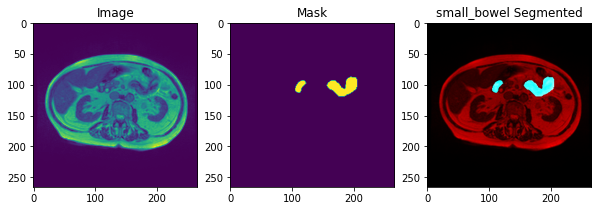

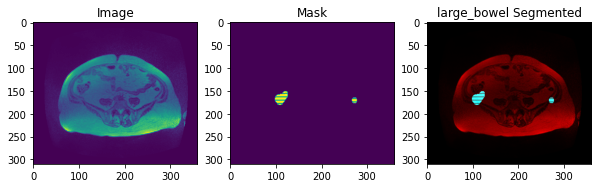

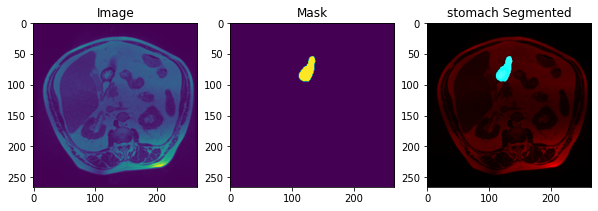

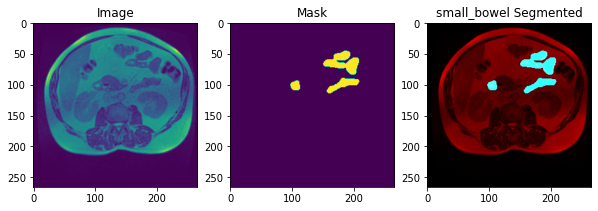

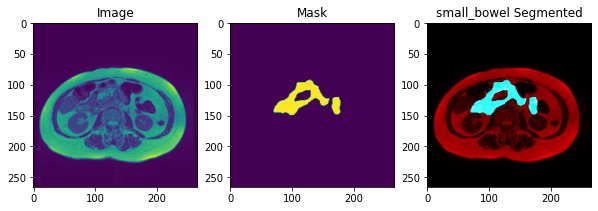

In [ ]:
# 원본, 마스킹된 부분, 마스킹된 부분과 원본 겹친 부분 비교 시각화
for i in range(5):
  index = index_list[np.random.randint(0,len(index_list) - 1)]

  curr_id = mask_data.loc[index, 'id']
  class_of_scan = mask_data.loc[index, 'class']

  splits = curr_id.split('_')
  x = image_details[(image_details['Case_no']==int(splits[0][4:]))
                  &(image_details['Day']==int(splits[1][3:]))
                  &(image_details['Slice_no']==int(splits[3]))]
  
  image = np.array(Image.open(x['img_path'].values[0]))
  k = image.shape

  rle_string = mask_data.loc[index, 'segmentation']
  p_loc = get_pixel_loc(rle_string, k)


  fig, ax = plt.subplots(1,3, figsize=(10,10))
  ax[0].set_title('Image')
  ax[0].imshow(image)

  ax[1].set_title('Mask')
  ax[1].imshow(get_mask(p_loc, k))

  ax[2].set_title(f'{class_of_scan} Segmented')
  ax[2].imshow(apply_mask(image, p_loc, k))
  plt.show()
  
plt.show()